In [72]:
from tqdm import tqdm
import os
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

In [24]:
prob_cutoff = 50

First we'll extract the a3ms from the defense finder database

In [8]:
df_a3m_dir = '../data3/interim/df_a3ms/'
if not os.path.exists(df_a3m_dir):
    os.mkdir(df_a3m_dir)

In [10]:
df_name_mapping = []
df_len_mapping
first = True
next_seq = False
for line in tqdm(open(os.path.expanduser('~/Documents/hhpred/data/hhsuite_dbs/df2/df_a3m.ffdata'), 'r')):
    if first:
        a3m_file = df_a3m_dir + line.split(' ')[0][1:] + '.a3m'
        df_name_mapping.append({'seq_id': line.split(' ')[0][1:], 
                                'defense_id': line.split(' ')[1]})
        out_file = open(a3m_file, 'w')
        out_file.write(line)
        first=False
    elif '~' in line:
        a3m_file = df_a3m_dir + line.split(' ')[0][2:] + '.a3m'
        df_name_mapping.append({'seq_id': line.split(' ')[0][2:], 
                                'defense_id': line.split(' ')[1]})
        out_file = open(a3m_file, 'w')
        out_file.write(line[1:])
    elif next_seq:
        
    else:
        out_file.write(line)
out_file.close()

3570313it [00:40, 89145.15it/s] 


In [11]:
df_name_mapping_df = pd.DataFrame(df_name_mapping)

## DefenseFinder Pfam domains

In [38]:
df_raw_out_dir = '../data3/interim/df_pfam_alignments/'
df_parsed_out_file = '../data3/interim/df_pfam_domains.csv'

In [37]:
%%time
os.system(' '.join(['conda run -n hhpred python',
                    '~/Documents/hhpred/code/hhpred.py',
                    '--raw_out_dir', df_raw_out_dir,
                    '--parsed_out_file', df_parsed_out_file, 
                    '--dbs pfam',
                    '--input_a3m_dir', 
                    df_a3m_dir]))

Using pre-built alignments in ../data3/interim/df_a3ms/
Querying pfam database(s)

CPU times: user 10.3 ms, sys: 870 µs, total: 11.2 ms
Wall time: 3min 37s


0

In [46]:
defense_finder_pfam_domains = pd.read_csv('../data3/interim/df_pfam_domains.csv')

In [47]:
defense_finder_pfam_domains = (defense_finder_pfam_domains.merge(df_name_mapping_df, left_on='query', right_on='seq_id'))

In [48]:
defense_finder_pfam_domains['pfam_id'] = [x.strip() for x in defense_finder_pfam_domains['Hit'].str.split('.', expand=True)[0]]
defense_finder_pfam_domains = defense_finder_pfam_domains.merge(pfam_clans, how='left', on='pfam_id')

In [49]:
blacklisted_domains = (defense_finder_pfam_domains[defense_finder_pfam_domains['Prob'] > prob_cutoff]
                    .sort_values('Prob', ascending=False)
                    .groupby(['Hit'])
                    .head(1))

In [50]:
blacklisted_domains['clan_name'].value_counts().head(20)

clan_name
HTH                245
P-loop_NTPase      211
NADP_Rossmann      137
TPR                 94
PDDEXK              93
AB_hydrolase        65
Zn_Beta_Ribbon      48
Peptidase_MA        31
NTF2                26
PKinase             25
Met_repress         25
NTP_transf          23
Peptidase_PA        22
TIM_barrel          22
HAD                 22
4Fe-4S              20
KNTase_C            19
vWA-like            17
CDA                 17
RAMPS-Cas5-like     16
Name: count, dtype: int64

In [51]:
len(blacklisted_domains)

2085

## Query DefenseFinder against itself

In [52]:
df_raw_out_dir = '../data3/interim/df_df_alignments/'
df_parsed_out_file = '../data3/interim/df_df_overlap.csv'

In [53]:
%%time
os.system(' '.join(['conda run -n hhpred python',
                    '~/Documents/hhpred/code/hhpred.py',
                    '--raw_out_dir', df_raw_out_dir,
                    '--parsed_out_file', df_parsed_out_file, 
                    '--dbs df2',
                    '--input_a3m_dir', 
                    df_a3m_dir]))

Using pre-built alignments in ../data3/interim/df_a3ms/
Querying df2 database(s)

CPU times: user 16 ms, sys: 6.23 ms, total: 22.2 ms
Wall time: 4min 17s


0

In [54]:
defense_finder_df_overlap = pd.read_csv('../data3/interim/df_df_overlap.csv')
defense_finder_df_overlap['target'] = defense_finder_df_overlap['hit_name'].str.split(' ', expand=True)[0]

In [64]:
defense_finder_df_overlap['target_len'] = (defense_finder_df_overlap['Template HMM']
                                           .str.extract('\(([0-9]+)\)', expand=True)
                                           .astype(int))
defense_finder_df_overlap['tstart'] = (defense_finder_df_overlap['Template HMM']
                                       .str.extract('([0-9]+)-')
                                       .astype(int))
defense_finder_df_overlap['tend'] = (defense_finder_df_overlap['Template HMM']
                                       .str.extract('-([0-9]+)')
                                       .astype(int))
defense_finder_df_overlap['tcov'] = defense_finder_df_overlap['Cols']/defense_finder_df_overlap['target_len']

In [65]:
defense_finder_df_overlap = (defense_finder_df_overlap
                             .merge(df_name_mapping_df, left_on='query', right_on='seq_id')
                             .merge(df_name_mapping_df, left_on='target', right_on='seq_id', 
                                    suffixes=('_query', '_target')))

In [158]:
defense_finder_df_overlap[(defense_finder_df_overlap['defense_id_query'] == 'Wadjet~JetC_II') & 
                          (defense_finder_df_overlap['defense_id_target'] == 'Wadjet~JetC_I')]

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,...,hit_name,target,target_len,tstart,tend,tcov,seq_id_query,defense_id_query,seq_id_target,defense_id_target
8520,UniRef50_A0A651EF56 Wadjet~Jet,100.0,4.800000e-44,4.600000e-47,459.1,0.0,227.0,1122-1359,876-1113(1137),UniRef50_F6BI68,...,UniRef50_A0A651EF56 Wadjet~JetC_I ATP-dependen...,UniRef50_A0A651EF56,1137,876,1113,0.199648,UniRef50_F6BI68,Wadjet~JetC_II,UniRef50_A0A651EF56,Wadjet~JetC_I
8521,UniRef50_A0A651EF56 Wadjet~Jet,74.2,2.900000e-02,2.700000e-05,60.0,0.0,53.0,1-53,14-68 (1137),UniRef50_F6BI68,...,UniRef50_A0A651EF56 Wadjet~JetC_I ATP-dependen...,UniRef50_A0A651EF56,1137,14,68,0.046614,UniRef50_F6BI68,Wadjet~JetC_II,UniRef50_A0A651EF56,Wadjet~JetC_I
8522,UniRef50_A0A651EF56 Wadjet~Jet,40.4,3.100000e-01,2.900000e-04,50.2,0.0,15.0,1307-1321,978-992 (1137),UniRef50_F6BI68,...,UniRef50_A0A651EF56 Wadjet~JetC_I ATP-dependen...,UniRef50_A0A651EF56,1137,978,992,0.013193,UniRef50_F6BI68,Wadjet~JetC_II,UniRef50_A0A651EF56,Wadjet~JetC_I


In [147]:
filtered_df_overlap = (defense_finder_df_overlap
                       [(defense_finder_df_overlap['Prob'] > prob_cutoff) &
                        (defense_finder_df_overlap['defense_id_query'] != 
                         defense_finder_df_overlap['defense_id_target'])]
                       .sort_values('Prob', ascending=False)
                       .groupby(['defense_id_query', 'defense_id_target'])
                       .head(1)
                       .sort_values('tcov', ascending=False))

In [156]:
cov_cutoffs = np.arange(0.1, 1, 0.1)

In [154]:
from IPython.display import display

In [157]:
for cutoff in cov_cutoffs:
    print(cutoff)
    filt_df = (filtered_df_overlap[filtered_df_overlap['tcov'] < cutoff])
    display(filt_df[['defense_id_query', 'defense_id_target', 
                     'Prob', 'E-value',
                     'tcov', 'Template HMM', 'Query HMM']].head(5))

0.1


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
2546,NLR_like_bNACHT01~NLR_like_bNACHT01,Pif~PifA,96.3,1.700000e-06,0.099865,195-283 (741),173-246
562,PARIS_II~AAA_21,Dnd~DndD,96.0,4.200000e-06,0.099849,555-626 (661),308-375
34501,Cas~cas10_III-B_8,Cas~cas10_III-D_2,97.4,1.600000e-08,0.099819,1-58 (551),1-55
17299,Gao_Her_SIR~HerA_SIR2,Cas~cas3_I-D_4,56.0,1.200000e-01,0.099744,55-93 (391),171-213
17366,PD-T7-2~PD-T7-2_B,Cas~cas3_I-D_4,58.8,9.900000e-02,0.099744,55-93 (391),170-211


0.2


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
6941,Stk2~Stk2,Mokosh_TypeI~MkoA,99.5,2.500000e-19,0.199664,22-284 (1192),124-401
8520,Wadjet~JetC_II,Wadjet~JetC_I,100.0,4.800000e-44,0.199648,876-1113(1137),1122-1359
4748,PARIS_II~AAA_21,AbiL~AbiLi2,99.1,1.400000e-15,0.199571,334-433 (466),307-400
10714,Cas~csm3gr7_III-D_7,Cas~csm4gr5_III-A_3,95.4,1.900000e-05,0.199468,3-81 (376),250-330
10754,Cas~csm3gr7_III-D_4,Cas~csm4gr5_III-A_3,96.1,3.200000e-06,0.199468,167-248 (376),92-172


0.30000000000000004


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
16771,Cas~cas12b1_V-B_1,Cas~cas12f1_V-F_1,99.4,1.000000e-18,0.30000,334-486 (500),781-991
34086,Cas~csx1_III_17,PD-Lambda-3~PD-Lambda-3_A,50.6,1.700000e-01,0.30000,86-127 (140),337-380
12351,Cas~csm3gr7_III-A_III-D_2,Cas~csm3gr7_III-D_7,99.8,1.900000e-25,0.30000,2-219 (620),7-234
15100,Cas~RT_I_II_III_IV_V_VI_1,DRT_3~drt3b,99.7,5.600000e-23,0.29985,54-318 (667),75-280
12637,Cas~cmr1gr7_III-B_4,Cas~cmr1gr7_III-B_3,99.9,3.700000e-30,0.29983,15-298 (587),1-183


0.4


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
33569,CBASS~Endonuc_big,Hachiman~HamA_2,99.2,1.000000e-16,0.399628,6-243 (538),3-257
32528,Cas~cas7b_I-B_1,Cas~cas7b_I-B_I-C_2,87.3,4.000000e-03,0.399306,1-150 (288),1-123
18703,Cas~cas12b2_V-B_2,Cas~cas12f3_V-F_1,99.8,4.600000e-25,0.399274,199-466 (551),395-699
28364,Dpd~DpdE,Zorya_TypeI~ZorD,99.9,4.300000e-32,0.399261,572-1064(1082),149-714
18983,Cas~cas12e_V-E_2,Cas~cas12f6_V-F_1,99.9,1.700000e-30,0.399076,315-597 (649),529-830


0.5


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
2790,radar_I~rdrA_I,Gao_Qat~QatA,99.9,5.000000e-29,0.499230,31-414 (649),69-415
27928,Cas~cas3_I_7,Cas~cas3d_I-D_1,99.9,9.000000e-30,0.499220,29-412 (641),8-373
16156,DRT7~DRT7_small,DRT8~DRT8,99.6,9.200000e-22,0.499048,6-277 (525),379-663
16150,Cas~RT_I_II_III_IV_V_VI_1,DRT8~DRT8,99.9,9.900000e-29,0.499048,3-285 (525),22-292
31446,Cas~cas8b2_I-B_6,Cas~cas8b2_I-B_8,97.5,5.800000e-09,0.499033,189-475 (517),144-428


0.6


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
13534,Cas~cmr3gr5_III-C_1,Cas~csf2gr7_IV-B_1,98.8,7.700000e-14,0.599315,2-260 (292),1-182
13143,Cas~csm3gr7_III_IV,Cas~cmr3gr5_III-C_1,99.4,4.700000e-18,0.599291,1-181 (282),7-233
30663,Cas~csm3gr7_III-D_3,Cas~csm3gr7_III-D_1,99.9,8.500000e-29,0.599278,1-253 (277),2-201
286,RosmerTA~RmrT_2664250653,RosmerTA~RmrT_2603008502,87.0,4.300000e-03,0.599190,5-196 (247),11-164
760,Cas~cas8a2_I-A_3,Cas~cas8a8_I-A_1,96.4,1.200000e-06,0.599182,12-328 (489),5-362


0.7000000000000001


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
33469,Dsr_II~Dsr2,PD-T7-2~PD-T7-2_A,99.5,3.600000e-20,0.70000,4-307 (340),6-257
33471,AVAST_V~Avs5A,PD-T7-2~PD-T7-2_A,99.5,2.700000e-20,0.70000,6-296 (340),9-253
27001,Cas~cas5_I-A_4,Cas~cas5_I-A_12,99.9,5.900000e-28,0.70000,1-171 (230),1-177
19451,Thoeris~ThsB_Global,Cas~cas2_I_II_III_IV_V_VI_8,55.4,1.200000e-01,0.70000,2-66 (90),1-68
14504,Menshen~NsnC_2623244837,Menshen~NsnC_2512642389,99.8,3.000000e-27,0.69967,1-230 (303),7-229


0.8


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
13935,Menshen~NsnC_2617187710,Menshen~NsnC_2623244837,99.9,5.800000e-30,0.799383,6-323 (324),1-275
9783,Cas~cas6_III_1,Cas~cas6_I_II_III_IV_V_VI_15,99.8,5.700000e-27,0.799363,47-305 (314),1-313
10188,Cas~cas6_III-D_5,Cas~cas6_I_II_III_IV_V_VI_11,99.8,6.500000e-26,0.799308,6-288 (289),3-267
35534,Dnd~DndC,CAS_Class1-Subtype-IV-B~cysH_IV-B_1,99.6,1.300000e-21,0.799296,21-267 (284),113-378
18829,Cas~cas12f1_V-F_2,Cas~cas12_x1_V-F_1,99.9,5.600000e-30,0.799031,8-394 (413),143-491


0.9


,defense_id_query,defense_id_target,Prob,E-value,tcov,Template HMM,Query HMM
26407,Cas~csf1gr8_IV-A_5,Cas~csf1gr8_IV-A_4,100.0,1.100000e-38,0.899543,3-217 (219),3-224
15612,Retron_I_C~RT_1_C1,Retron_I_C~RT_1_C3,100.0,1.400000e-51,0.899480,8-576 (577),3-572
31792,Cas~csx19_III-D_15,Cas~csx19_III-D_14,100.0,2.200000e-43,0.899281,8-138 (139),17-160
33120,Cas~csx19_III-D_17,Cas~csx19_III-D_12,99.9,6.200000e-30,0.899281,4-133 (139),6-133
17858,RosmerTA~RmrA_2603008502,RosmerTA~RmrA_2664250653,100.0,6.900000e-48,0.899244,24-385 (397),2-375


<Axes: xlabel='tcov', ylabel='Count'>

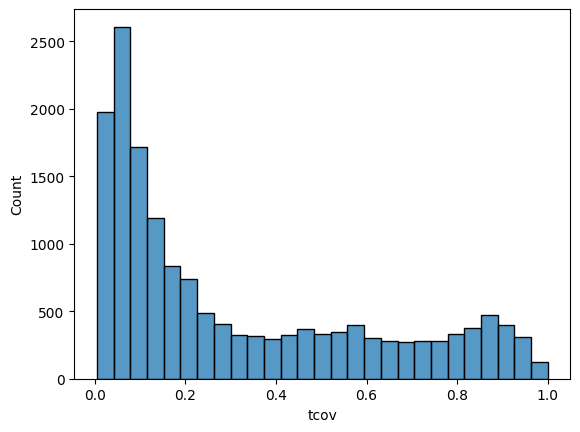

In [70]:
sns.histplot(data=filtered_df_overlap, x='tcov')

## Output

In [160]:
blacklisted_domains.to_csv('../data3/interim/df_blacklisted_domains.csv', index=False)